# Analysis of the deformation in linescan measurements by image registration

## Import libraries

In [1]:
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import clear_output

import numpy as np

In [3]:
import SimpleITK as sitk
print(sitk.Version())

image_viewer = sitk.ImageViewer()
image_viewer.SetCommand('/home/alexandra/Slicer-4.11.20210226-linux-amd64/Slicer')

SimpleITK Version: 2.0.0rc2 (ITK 5.1)
Compiled: Jun 30 2020 13:57:21



In [4]:
import sys
sys.path.append("../") # go to parent dir
from src.datanalysis import lowpassfilter

## Import data

In [5]:
# previously analysed interface location 
#data=pd.read_csv('/home/alexandra/Documents/Data/Laura/Linescans/270122_4traces/PenetratingArterioles/WT 10 20210226 07 Penetrating Arteriole 093.csv', decimal='.', delimiter=",")

data=pd.read_csv('/home/alexandra/Documents/Data/Laura/Linescans/270122_4traces/PenetratingArterioles/WT 06 20201008 11 Penetrating Arteriole 047.csv', decimal='.', delimiter=",")


In [6]:
# previoulsy analysed peak to peak 
#peaktopeakPVS=pd.read_pickle('/home/alexandra/Documents/Python/linescan-analysis/output/databases/cleanPenetratingArteriolesWT3/cleanPenetratingArteriolesWT3_WT-10-07-093-PVS.pkl')
#peaktopeakLumen=pd.read_pickle('/home/alexandra/Documents/Python/linescan-analysis/output/databases/cleanPenetratingArteriolesWT3/cleanPenetratingArteriolesWT3_WT-10-07-093-lumen.pkl')

peaktopeakPVS=pd.read_pickle('/home/alexandra/Documents/Python/linescan-analysis/output/databases/cleanPenetratingArteriolesWT3/cleanPenetratingArteriolesWT3_WT-06-11-047-PVS.pkl')
peaktopeakLumen=pd.read_pickle('/home/alexandra/Documents/Python/linescan-analysis/output/databases/cleanPenetratingArteriolesWT3/cleanPenetratingArteriolesWT3_WT-06-11-047-lumen.pkl')

In [13]:
# raw data
#tiffgreen = sitk.ReadImage("/home/alexandra/Documents/Data/Laura/Linescans/raw_images/WT 10 20210226 07 endfoot.tif")
#tiffred = sitk.ReadImage("/home/alexandra/Documents/Data/Laura/Linescans/raw_images/WT 10 20210226 07 lumen.tif")

tiffgreen = sitk.ReadImage('/home/alexandra/Documents/Data/Laura/Linescans/raw_images/WT 06 20201008 11 endfoot.tif')
tiffred = sitk.ReadImage('/home/alexandra/Documents/Data/Laura/Linescans/raw_images/WT 06 20201008 11 lumen.tif')

In [14]:
Arraygreen=sitk.GetArrayFromImage(tiffgreen)
Arrayred=sitk.GetArrayFromImage(tiffred)

In [15]:
Arraygreen.shape

(500, 155000)

In [16]:
#number of pixels
Nx=len(Arrayred[:,0])

In [17]:
fs=124.975
ts=1/fs
dx=0.049118267393604
#dx=0.047585266541569

In [18]:
# time vector
spantime=np.arange(len(data))*ts

## Selection of time window of interest

In [19]:
peaktopeak=peaktopeakLumen

iscardiac=peaktopeak['bandname']=='cardiac'
highamp=(peaktopeak['amp']/peaktopeak['mean']>0.08)
peaktopeak[iscardiac&highamp]['tmin']

1845    385.885177
2321    471.630326
3038    420.284057
3039    420.284057
3061    422.204441
3082    423.964793
Name: tmin, dtype: float64

In [20]:
# initial time and time window

tini=420 #sec
timewindow=4 #sec

tini_index=np.where(spantime>=tini)[0][0]
Ntime=round(timewindow*fs)
tend_index=tini_index+Ntime

In [21]:
initialtraces={}

initialtraces['endfoot_bottom']=data['endfoot_lower'][tini_index:tend_index]
initialtraces['lumen_bottom']=data['lumen_lower'][tini_index:tend_index]
initialtraces['endfoot_top']=data['endfoot_upper'][tini_index:tend_index]
initialtraces['lumen_top']=data['lumen_upper'][tini_index:tend_index]

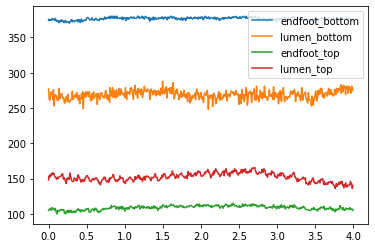

In [22]:
for label in initialtraces :
    plt.plot(np.arange(Ntime)*ts,np.array(initialtraces[label])/dx,label=label)
    
plt.legend()

## Define useful functions for registration analysis

In [23]:
sitk.ProcessObject.SetGlobalWarningDisplay(False)

In [24]:
import registration_callbacks

In [25]:
def myshow(img, title=None, margin=0.05, dpi=80):
    nda =  sitk.GetArrayFromImage(img)

    ysize = nda.shape[0]
    xsize = nda.shape[1]
      
   # figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi

    fig = plt.figure(title) #, figsize=figsize, dpi=dpi)
    #ax = fig.add_axes()
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    #extent = (0, xsize*spacing[1], 0, ysize*spacing[0])
    
    t = ax.imshow(nda,
            #extent=extent,
            interpolation='hamming',
            cmap='gray',
            origin='lower',
            aspect=2)
    
    if(title):
        plt.title(title)

In [26]:
def resample(image, transform):
    # Output image Origin, Spacing, Size, Direction are taken from the reference
    # image in this call to Resample
    reference_image = image
    interpolator = sitk.sitkCosineWindowedSinc
    default_value = 100.0
    return sitk.Resample(image, reference_image, transform,
                         interpolator, default_value)

In [27]:
def get_deformation(image, transform):
    x, y = image.GetSize()
    X, Y = np.meshgrid(np.arange(0, x, 1), np.arange(0, y, 1))
    
    U = np.zeros(X.shape)
    V = np.zeros(Y.shape)
    for index, value in np.ndenumerate(X):
        px, py = transform.TransformPoint((float(value), float(Y[index])))
        U[index] = px - value
        V[index] = py - Y[index]
    
    return U,V

## Visualise the two channels

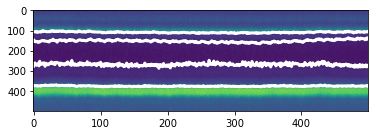

In [28]:
image2Dgreen=np.array(Arraygreen[:,tini_index:tend_index])
plt.imshow(image2Dgreen,aspect=0.3)

for label in initialtraces :
    plt.plot(np.arange(Ntime),np.array(initialtraces[label])/dx,label=label,linewidth=3,c='w')

In [ ]:
image2Dred=np.array(Arrayred[:,tini_index:tend_index])
plt.imshow(image2Dred,aspect=0.3)

for label in initialtraces :
    plt.plot(np.arange(Ntime),np.array(initialtraces[label])/dx,label=label,linewidth=3,c='w')

In [ ]:
image2DRGB=np.zeros((np.size(image2Dgreen,0),np.size(image2Dgreen,1),3),'uint8')
image2DRGB[...,0]=image2Dred/image2Dred.max()*256
image2DRGB[...,1]=image2Dgreen/image2Dgreen.max()*256
image2DRGB=image2DRGB.astype('float32')
plt.figure(figsize=(8,8))
plt.imshow(image2DRGB/300,aspect=0.5)

for label in initialtraces :
    plt.plot(np.arange(Ntime),np.array(initialtraces[label])/dx,label=label,linewidth=3,c='w')
    

In [ ]:
# Localisation of the markers in the initial frame
deltax=5
shift=2

ranges={}
upper={}
lower={}

upper['endfoot_bottom']=shift+30+5
lower['endfoot_bottom']=shift+5

upper['endfoot_top']=0
lower['endfoot_top']=-30

upper['lumen_bottom']=shift+10+10
lower['lumen_bottom']=shift+10

upper['lumen_top']=0
lower['lumen_top']=-10

for label in initialtraces :
    ranges[label]=range(round(np.array(initialtraces[label])[0]/dx)+lower[label],round(np.array(initialtraces[label])[0]/dx)+upper[label])


In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(image2DRGB/300,aspect=0.5)

for label in ranges :
    plt.plot([0,Ntime],[np.array(ranges[label])[0],np.array(ranges[label])[0]],'w')
    plt.plot([0,Ntime],[np.array(ranges[label])[-1],np.array(ranges[label])[-1]],'w')

for label in initialtraces :
    plt.plot(np.arange(Ntime),np.array(initialtraces[label])/dx,label=label,linewidth=3,c='b')

In [ ]:
ranges

# Rigid transformation

In [ ]:
spantranslation={}

In [ ]:
testlabel='green'

In [ ]:
def rigid_transform(fixedimage,movingimage) :
    R = sitk.ImageRegistrationMethod()

    R.SetOptimizerWeights([0,0,1,1])

    # This is more robust if intensities change
    R.SetMetricAsCorrelation()

    # I tryed several parameters here, it is robust
    R.SetOptimizerAsRegularStepGradientDescent(learningRate=2.0,
                                               minStep=1e-2,
                                               numberOfIterations=100,
                                               gradientMagnitudeTolerance=1e-4)
    R.SetOptimizerScalesFromIndexShift()


    tx = sitk.CenteredTransformInitializer(fixedimage, movingimage,sitk.Similarity2DTransform())

    R.SetInitialTransform(tx)

    R.SetInterpolator(sitk.sitkLinear)

    #R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

    return  R.Execute(fixedimage, movingimage)

In [ ]:
# Let's try a loop over the N first frames
nrows=4
# pourcentage of green channel
alpha=1


inputimage=np.zeros([Nx,Ntime])
correctedtranslation=np.zeros([Nx,Ntime])


# template from first image
image2Dgreen=np.array([Arraygreen[:,tini_index] for line in range(0,nrows)]).astype('float32')
image2Dred=np.array([Arrayred[:,tini_index] for line in range(0,nrows)]).astype('float32')
fixedimage= sitk.GetImageFromArray(alpha*image2Dgreen+(1-alpha)*image2Dred)

correctedtranslation[:,0]=sitk.GetArrayFromImage(fixedimage)[0,:]

#create a translation object
translation = sitk.TranslationTransform(2)

#initialise offset
yoffset=0

spantranslation[testlabel]=[]

for i in range(0,Ntime) :
    image2Dgreen=np.array([Arraygreen[:,tini_index+i] for line in range(0,nrows)]).astype('float32')
    image2Dred=np.array([Arrayred[:,tini_index+i] for line in range(0,nrows)]).astype('float32') 
    movingimage=sitk.GetImageFromArray(alpha*image2Dgreen+(1-alpha)*image2Dred)
    
    outTx = rigid_transform(fixedimage, movingimage)
    yoffset=outTx.GetParameters()[2]
    
    spantranslation[testlabel].append(yoffset)
    
    translation.SetParameters((yoffset,0))
    
    resampled = resample(movingimage, translation)
    
    inputimage[:,i]=sitk.GetArrayFromImage(movingimage)[0,:]
    correctedtranslation[:,i]=sitk.GetArrayFromImage(resampled)[0,:]
    
    fixedimage=resampled    

In [ ]:
for testlabel in spantranslation :
    plt.plot(np.arange(Ntime)*ts,np.array(spantranslation[testlabel])*dx,label=testlabel)

plt.title('Ridig translation')
plt.xlabel('time')
plt.ylabel('translation (um)')
plt.legend()

In [ ]:
# Lets do a bit of trigo to estimate the possible wall movement artefact due to motion
rigidmotion=0.4 #um
vesselradius=2 # um when contracted

theta=np.arcsin(rigidmotion/vesselradius)

artefact=vesselradius*(1-np.cos(theta))

print('cardiac artifact to be expected: %.2f um'%artefact)


rigidmotion=0.7 #um
vesselradius=3 # um

theta=np.arcsin(rigidmotion/vesselradius)

artefact=vesselradius*(1-np.cos(theta))

print('VLF artifact to be expected: %.2f um'%artefact)

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(inputimage,aspect=0.6)

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(correctedtranslation,aspect=0.6)

for label in ranges :
    plt.plot([0,Ntime],[np.array(ranges[label])[0],np.array(ranges[label])[0]],'w')
    plt.plot([0,Ntime],[np.array(ranges[label])[-1],np.array(ranges[label])[-1]],'w')

# Let compute the mixed image with movment correction

In [ ]:
# choose your translation correction label
testlabel=testlabel

# Let's try a loop over the N first frames
nrows=4
# pourcentage of green channel
alpha=0.6


inputimage=np.zeros([Nx,Ntime])
correctedtranslation=np.zeros([Nx,Ntime])


# template from first image
image2Dgreen=np.array([Arraygreen[:,tini_index] for line in range(0,nrows)]).astype('float32')
image2Dred=np.array([Arrayred[:,tini_index] for line in range(0,nrows)]).astype('float32')
fixedimage= sitk.GetImageFromArray(alpha*image2Dgreen+(1-alpha)*image2Dred)

correctedtranslation[:,0]=sitk.GetArrayFromImage(fixedimage)[0,:]

#create a translation object
translation = sitk.TranslationTransform(2)

for i in range(0,Ntime) :
    image2Dgreen=np.array([Arraygreen[:,tini_index+i] for line in range(0,nrows)]).astype('float32')
    image2Dred=np.array([Arrayred[:,tini_index+i] for line in range(0,nrows)]).astype('float32') 
    movingimage=sitk.GetImageFromArray(alpha*image2Dgreen+(1-alpha)*image2Dred)

    translation.SetParameters((spantranslation[testlabel][i],0))
    
    resampled = resample(movingimage, translation)
    
    inputimage[:,i]=sitk.GetArrayFromImage(movingimage)[0,:]
    correctedtranslation[:,i]=sitk.GetArrayFromImage(resampled)[0,:]

In [ ]:
margin=20
correctedtranslationcrop=correctedtranslation[margin:-margin,:]

plt.figure(figsize=(8,8))
plt.imshow(correctedtranslationcrop,aspect=0.6)

for label in ranges :
    plt.plot([0,Ntime],[np.array(ranges[label])[0]-margin,np.array(ranges[label])[0]-margin],'w')
    plt.plot([0,Ntime],[np.array(ranges[label])[-1]-margin,np.array(ranges[label])[-1]-margin],'w')

# Non-rigid deformation

## Separated affine registration for endfoot and lumen

In [ ]:
#initial transform

# template from first image
image2Dgreen=np.array([Arraygreen[:,0] for line in range(0,10)]).astype('float32')
image2Dred=np.array([Arrayred[:,0] for line in range(0,10)]).astype('float32')
fixedimage= sitk.GetImageFromArray(alpha*image2Dgreen+(1-alpha)*image2Dred)

image2Dgreen=np.array([Arraygreen[:,1] for line in range(0,10)]).astype('float32')
image2Dred=np.array([Arrayred[:,1] for line in range(0,10)]).astype('float32')
movingimage= sitk.GetImageFromArray(alpha*image2Dgreen+(1-alpha)*image2Dred)


In [ ]:
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsCorrelation()
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)
registration_method.SetInterpolator(sitk.sitkLinear)

#registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=300)

registration_method.SetOptimizerAsRegularStepGradientDescent(learningRate=2.0,
                                           minStep=1e-2,
                                           numberOfIterations=100,
                                           gradientMagnitudeTolerance=1e-4)

# Scale the step size differently for each parameter, this is critical!!!
registration_method.SetOptimizerScalesFromPhysicalShift() 

global_transform = sitk.CenteredTransformInitializer(fixedimage, movingimage, sitk.AffineTransform(2), 
                                                     sitk.CenteredTransformInitializerFilter.GEOMETRY)
registration_method.SetInitialTransform(global_transform, inPlace=True)

registration_method.AddCommand(sitk.sitkStartEvent, registration_callbacks.metric_start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, registration_callbacks.metric_end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, 
                              registration_callbacks.metric_update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, 
                              lambda: registration_callbacks.metric_plot_values(registration_method))

registration_method.Execute(fixed=fixedimage, moving=movingimage)
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))

In [ ]:
# same without the output
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsCorrelation()
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.1)
registration_method.SetInterpolator(sitk.sitkLinear)

registration_method.SetOptimizerAsGradientDescent(learningRate=2.0, numberOfIterations=300)

registration_method.SetOptimizerScalesFromPhysicalShift() 

registration_method.SetOptimizerWeights([1,1,1,1,1,0])


In [ ]:
# Let's try a loop over the N first frames
N=200

# pourcentage of green channel
alpha=0

# the reference template will be an average of windowsize frames --> only if deformation
windowsize=5


inputimage=np.zeros((len(Arrayred[:,0]),N))
correctedimage=np.zeros((len(Arrayred[:,0]),N))


# template from first image
image2Dgreen=np.array([Arraygreen[:,0] for line in range(0,nrows)]).astype('float32')
image2Dred=np.array([Arrayred[:,0] for line in range(0,nrows)]).astype('float32')
fixedimage= sitk.GetImageFromArray(alpha*image2Dgreen+(1-alpha)*image2Dred)

image2Dgreen=np.array([Arraygreen[:,1] for line in range(0,nrows)]).astype('float32')
image2Dred=np.array([Arrayred[:,1] for line in range(0,nrows)]).astype('float32')
movingimage= sitk.GetImageFromArray(alpha*image2Dgreen+(1-alpha)*image2Dred)

#first images
inputimage[:,0]=sitk.GetArrayFromImage(fixedimage)[0,:]
correctedimage[:,0]=sitk.GetArrayFromImage(fixedimage)[0,:]

global_transform = sitk.CenteredTransformInitializer(fixedimage, movingimage, sitk.AffineTransform(2), 
                                                     sitk.CenteredTransformInitializerFilter.GEOMETRY)
registration_method.SetInitialTransform(global_transform, inPlace=True)


for i in range(1,N) :
    image2Dgreen=np.array([Arraygreen[:,i] for line in range(0,nrows)]).astype('float32')
    image2Dred=np.array([Arrayred[:,i] for line in range(0,nrows)]).astype('float32') 
    
    movingimage=sitk.GetImageFromArray(alpha*image2Dgreen+(1-alpha)*image2Dred)
    
    #tx = sitk.CenteredTransformInitializer(fixedimage, movingimage,sitk.Similarity2DTransform())
    #R.SetInitialTransform(tx)
    outTx = registration_method.Execute(fixed=fixedimage, moving=movingimage)
    
    
    resampled = resample(movingimage, outTx)
    
    
    inputimage[:,i]=sitk.GetArrayFromImage(movingimage).mean(axis=0)
    correctedimage[:,i]=sitk.GetArrayFromImage(resampled).mean(axis=0)
    
    templateimage=correctedimage[:,0:i+1].mean(axis=1).astype('float32') #max(i-windowsize,0)
    image2Dtemplate=np.array([templateimage for line in range(0,nrows)]).astype('float32')
    
    fixedimage=sitk.GetImageFromArray(image2Dtemplate)

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(correctedimage,aspect=0.6)

In [ ]:
print(outTx)

## Non-rigid deformation

In [ ]:
def smooth_and_resample(image, shrink_factors, smoothing_sigmas):
    """
    Args:
        image: The image we want to resample.
        shrink_factor(s): Number(s) greater than one, such that the new image's size is original_size/shrink_factor.
        smoothing_sigma(s): Sigma(s) for Gaussian smoothing, this is in physical units, not pixels.
    Return:
        Image which is a result of smoothing the input and then resampling it using the given sigma(s) and shrink factor(s).
    """
    if np.isscalar(shrink_factors):
        shrink_factors = [shrink_factors]*image.GetDimension()
    if np.isscalar(smoothing_sigmas):
        smoothing_sigmas = [smoothing_sigmas]*image.GetDimension()

    smoothed_image = sitk.SmoothingRecursiveGaussian(image, smoothing_sigmas)
    
    original_spacing = image.GetSpacing()
    original_size = image.GetSize()
    new_size = [int(sz/float(sf) + 0.5) for sf,sz in zip(shrink_factors,original_size)]
    new_spacing = [((original_sz-1)*original_spc)/(new_sz-1) 
                   for original_sz, original_spc, new_sz in zip(original_size, original_spacing, new_size)]
    return sitk.Resample(smoothed_image, new_size, sitk.Transform(), 
                         sitk.sitkLinear, image.GetOrigin(),
                         new_spacing, image.GetDirection(), 0.0, 
                         image.GetPixelID())


    
def multiscale_demons(registration_algorithm,
                      fixed_image, moving_image, initial_transform = None, 
                      shrink_factors=None, smoothing_sigmas=None, output=False):
    """
    Run the given registration algorithm in a multiscale fashion. The original scale should not be given as input as the
    original images are implicitly incorporated as the base of the pyramid.
    Args:
        registration_algorithm: Any registration algorithm that has an Execute(fixed_image, moving_image, displacement_field_image)
                                method.
        fixed_image: Resulting transformation maps points from this image's spatial domain to the moving image spatial domain.
        moving_image: Resulting transformation maps points from the fixed_image's spatial domain to this image's spatial domain.
        initial_transform: Any SimpleITK transform, used to initialize the displacement field.
        shrink_factors (list of lists or scalars): Shrink factors relative to the original image's size. When the list entry, 
                                                   shrink_factors[i], is a scalar the same factor is applied to all axes.
                                                   When the list entry is a list, shrink_factors[i][j] is applied to axis j.
                                                   This allows us to specify different shrink factors per axis. This is useful
                                                   in the context of microscopy images where it is not uncommon to have
                                                   unbalanced sampling such as a 512x512x8 image. In this case we would only want to 
                                                   sample in the x,y axes and leave the z axis as is: [[[8,8,1],[4,4,1],[2,2,1]].
        smoothing_sigmas (list of lists or scalars): Amount of smoothing which is done prior to resmapling the image using the given shrink factor. These
                          are in physical (image spacing) units.
    Returns: 
        SimpleITK.DisplacementFieldTransform
    """
    # Create image pyramid.
    fixed_images = [fixed_image]
    moving_images = [moving_image]
    if shrink_factors:
        for shrink_factor, smoothing_sigma in reversed(list(zip(shrink_factors, smoothing_sigmas))):
            fixed_images.append(smooth_and_resample(fixed_images[0], shrink_factor, smoothing_sigma))
            moving_images.append(smooth_and_resample(moving_images[0], shrink_factor, smoothing_sigma))
    
    # Create initial displacement field at lowest resolution. 
    # Currently, the pixel type is required to be sitkVectorFloat64 because of a constraint imposed by the Demons filters.
    if initial_transform:
        initial_displacement_field = sitk.TransformToDisplacementField(initial_transform, 
                                                                       sitk.sitkVectorFloat64,
                                                                       fixed_images[-1].GetSize(),
                                                                       fixed_images[-1].GetOrigin(),
                                                                       fixed_images[-1].GetSpacing(),
                                                                       fixed_images[-1].GetDirection())

        
    else:
        #initial_displacement_field = sitk.Image(fixed_images[-1].GetWidth(), 
        #                                        fixed_images[-1].GetHeight(),
        #                                        fixed_images[-1].GetDepth(),
        #                                        sitk.sitkVectorFloat64)
        
        #initial_displacement_field.CopyInformation(fixed_images[-1])
        initial_displacement_field = registration_algorithm.Execute(fixed_images[-1],moving_images[-1])

 
    # Run the registration.
    initial_displacement_field = registration_algorithm.Execute(fixed_images[-1],moving_images[-1],initial_displacement_field)
        
    # Start at the top of the pyramid and work our way down.    
    for f_image, m_image in reversed(list(zip(fixed_images[0:-1], moving_images[0:-1]))):
            initial_displacement_field = sitk.Resample (initial_displacement_field, f_image)
            initial_displacement_field = registration_algorithm.Execute(f_image, m_image, initial_displacement_field)
    
    
    
    return sitk.DisplacementFieldTransform(initial_displacement_field)

In [ ]:
# Select a Demons filter and configure it.
#demons_filter =  sitk.FastSymmetricForcesDemonsRegistrationFilter()
demons_filter= sitk.DiffeomorphicDemonsRegistrationFilter()
#DemonsRegistrationFilter
#DiffeomorphicDemonsRegistrationFilter
#FastSymmetricForcesDemonsRegistrationFilter
#SymmetricForcesDemonsRegistrationFilter


demons_filter.SetNumberOfIterations(50)
# Regularization (update field - viscous, total field - elastic).
demons_filter.SetSmoothDisplacementField(True)
demons_filter.SetStandardDeviations(1.0)


In [ ]:
# template from first image
image2D=np.array([correctedtranslationcrop[:,0] for line in range(0,nrows)]).astype('float32')
fixedimage_index= sitk.GetImageFromArray(image2D)

image2D=np.array([correctedtranslationcrop[:,-1] for line in range(0,nrows)]).astype('float32')
movingimage_index= sitk.GetImageFromArray(image2D)

# Run the registration.
tx = multiscale_demons(registration_algorithm=demons_filter, 
                       fixed_image = fixedimage_index, 
                       moving_image = movingimage_index,
                       shrink_factors = [2],
                       smoothing_sigmas = [8,4],
                       output=True)

In [ ]:
myshow(fixedimage_index, 'Initial frame')
myshow(movingimage_index, 'Final frame')
resampled = resample(movingimage_index, tx)
myshow(resampled, 'Resampled Transformed')

In [ ]:
deformations={}

for label in ranges :
    deformations[label]=[]
    
for label in ranges :
        deformations[label].append(0.)
# the reference template will be an average of windowsize frames --> only if deformation
windowsize=10


correctedimage=np.zeros((Nx-2*margin,Ntime))
deformationimage=np.zeros((Nx-2*margin,Ntime))

# template from first image
image2D=np.array([correctedtranslationcrop[:,0] for line in range(0,nrows)]).astype('float32')
fixedimage= sitk.GetImageFromArray(image2D)
correctedimage[:,0]=sitk.GetArrayFromImage(fixedimage)[0,:]


for i in range(1,Ntime) :
    image2D=np.array([correctedtranslationcrop[:,i] for line in range(0,nrows)]).astype('float32')
    movingimage= sitk.GetImageFromArray(image2D)
    
    outTx = multiscale_demons(registration_algorithm=demons_filter, 
                       fixed_image = fixedimage, 
                       moving_image = movingimage,
                       shrink_factors = [2],
                       smoothing_sigmas = [8,4])
        
    resampled = resample(movingimage, outTx)
        
    correctedimage[:,i]=sitk.GetArrayFromImage(resampled).mean(axis=0)
    
    
    U,V=get_deformation(fixedimage, outTx)
    
    for label in ranges :
        deformations[label].append(U[0,np.array(ranges[label])-margin].mean())
        
    deformationimage[:,i]=U.mean(axis=0)
    
    #templateimage=correctedimage[:,max(i-windowsize,0):i].mean(axis=1).astype('float32') 
    templateimage=correctedimage[:,0:min(windowsize,i)].mean(axis=1).astype('float32')
    image2Dtemplate=np.array([templateimage for line in range(0,nrows)]).astype('float32')
    
    fixedimage=sitk.GetImageFromArray(image2Dtemplate)

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(correctedimage,aspect=0.6)

for label in ranges :
    plt.plot([0,Ntime],[np.array(ranges[label])[0]-margin,np.array(ranges[label])[0]-margin],'r')
    plt.plot([0,Ntime],[np.array(ranges[label])[-1]-margin,np.array(ranges[label])[-1]-margin],'r')

In [ ]:
from matplotlib import cm as CM
from scipy import ndimage

# smooth deformations
deformationimage_smooth=ndimage.gaussian_filter(deformationimage, (0, 5))

velocityimage=np.diff(deformationimage_smooth,axis=0)

x_grid=np.arange(0,Ntime)*ts
y_grid=np.arange(0,Nx-margin*2)*dx
x_mesh,y_mesh=np.meshgrid(x_grid,y_grid)

plt.figure(figsize=(8,8))
plt.pcolormesh(x_mesh,y_mesh,velocityimage,cmap=CM.jet,vmin=-1,vmax=1)

plt.colorbar()
for label in ranges :
    plt.plot([0,Ntime*ts],[(np.array(ranges[label])[0]-margin)*dx,(np.array(ranges[label])[0]-margin)*dx],'w')
    plt.plot([0,Ntime*ts],[(np.array(ranges[label])[-1]-margin)*dx,(np.array(ranges[label])[-1]-margin)*dx],'w')

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(correctedtranslationcrop,aspect=0.6)

# Methods comparisons

In [ ]:
from scipy.signal import savgol_filter

In [ ]:
def extract_diameter(scanline,initialtraces,deformations) :
    
    cutoff=25
    
    bottom=np.array(initialtraces[scanline+'_bottom'])
    top=np.array(initialtraces[scanline+'_top'])


    diameter=bottom-top
    
    #diameter_th=lowpassfilter(diameter,fs,cutoff)
    top_th=savgol_filter(top,11,3)
    bottom_th=savgol_filter(bottom,11,3)
    
    bottom=np.array(deformations[scanline+'_bottom'])*dx+np.array(initialtraces[scanline+'_bottom'])[0]
    top=np.array(deformations[scanline+'_top'])*dx+np.array(initialtraces[scanline+'_top'])[0]


    diameter=bottom-top
    
    #diameter_reg=lowpassfilter(diameter,fs,cutoff)
    top_reg=savgol_filter(top,11,3)
    bottom_reg=savgol_filter(bottom,11,3)

    
    return (top_th,bottom_th,top_reg,bottom_reg)

In [ ]:
endfoot_top_th,endfoot_bottom_th,endfoot_top_reg,endfoot_bottom_reg=extract_diameter('endfoot',initialtraces,deformations)
endfoot_th=-(endfoot_top_th-endfoot_bottom_th)
endfoot_reg=-(endfoot_top_reg-endfoot_bottom_reg)

lumen_top_th,lumen_bottom_th,lumen_top_reg,lumen_bottom_reg=extract_diameter('lumen',initialtraces,deformations)
lumen_th=-(lumen_top_th-lumen_bottom_th)
lumen_reg=-(lumen_top_reg-lumen_bottom_reg)

pvs_top_th=lumen_top_th-endfoot_top_th
pvs_top_reg=lumen_top_reg-endfoot_top_reg

pvs_bottom_th=-(lumen_bottom_th-endfoot_bottom_th)
pvs_bottom_reg=-(lumen_bottom_reg-endfoot_bottom_reg)
                


plt.figure()
plt.plot(np.arange(Ntime)*ts,endfoot_th,':',label='threshold',linewidth=1)
plt.plot(np.arange(Ntime)*ts,endfoot_reg,label='registration',linewidth=1)
plt.title('Diameter of endfoot')
plt.legend()

plt.figure()
plt.plot(np.arange(Ntime)*ts,lumen_th,':',label='threshold',linewidth=1)
plt.plot(np.arange(Ntime)*ts,lumen_reg,label='registration',linewidth=1)
plt.title('Diameter of lumen')
plt.legend()

plt.figure()
plt.plot(np.arange(Ntime)*ts,pvs_top_th,':',label='threshold top',linewidth=1)
plt.plot(np.arange(Ntime)*ts,pvs_top_reg,label='registration top',linewidth=1)

plt.plot(np.arange(Ntime)*ts,pvs_bottom_th,':',label='threshold bot',linewidth=1)
plt.plot(np.arange(Ntime)*ts,pvs_bottom_reg,label='registration bot',linewidth=1)
plt.title('Diameter of PVS ')
plt.legend()


In [ ]:
for label in ranges :
    plt.plot(np.arange(len(deformations[label]))*ts,savgol_filter(np.array(deformations[label])*dx,15,3),label=label)
    
plt.legend()

In [ ]:
# to do : try separate analysis for the two channels.